# Settings

In [2]:
# Load Reticulate function
Sys.setenv(RETICULATE_PYTHON="/home/luca/anaconda3/envs/reticulate/bin/python")
library(reticulate)
reticulate::use_python("/home/luca/anaconda3/envs/reticulate/bin/python")
reticulate::use_condaenv("/home/luca/anaconda3/envs/reticulate")
reticulate::py_module_available(module='anndata') #needs to be TRUE
reticulate::import('anndata') #good to make sure this doesn't error
reticulate::py_module_available(module='leidenalg') #needs to be TRUE
reticulate::import('leidenalg') #good to make sure this doesn't error

[1] TRUE

Module(anndata)

[1] TRUE

Module(leidenalg)

In [3]:
## Patch for annotations in R4.1
# BiocManager::install("Bioconductor/GenomeInfoDb",lib = "/home/luca/R/x86_64-pc-linux-gnu-library/4.1",force = TRUE)
# library(GenomeInfoDb,lib.loc="/home/luca/R/x86_64-pc-linux-gnu-library/4.1")

In [4]:
# Load packages
pacman::p_load(dplyr, stringr, data.table, tidyr, data.table, Matrix, future, 
               hdf5r, Seurat, Signac,harmony, knitr, SoupX, 
               EnsDb.Hsapiens.v86, 
               logr, parallel, 
               ggplot2, ggpubr, ggrepel, ggbreak, gridExtra, patchwork, grid, ggh4x)

In [5]:
# Load genome
#suppressMessages(annotations <- GetGRangesFromEnsDb(ensdb=EnsDb.Hsapiens.v86))
#genome(annotations) <- 'hg38'
#seqlevelsStyle(annotations) <- 'UCSC'
# Save table
# writeRDS(annotations, "/nfs/lab/Luca/Assets/references/Cellranger/hg38.annotations.rds")

# Load table
annotations = readRDS("/nfs/lab/Luca/Assets/references/Cellranger/hg38.annotations.rds")
seqlevelsStyle(annotations) <- 'UCSC'
genome(annotations) <- 'hg38'

# Seq info downloaded from: https://github.com/broadinstitute/ichorCNA/issues/84
seq.info = readRDS("/nfs/lab/Luca/Assets/references/Cellranger/seqinfo_hg38_ucsc.rds")

In [63]:
# Set options
options(stringsAsFactors = FALSE)
warnLevel <- getOption('warn')
options(warn = -1)
opts_chunk$set(tidy=TRUE)

# set Future
plan("multicore", workers = 10)
# set RAM treshold
## 1000 = 1gb
RAM.tresh = 10000 * 1024^2
options(future.globals.maxSize = RAM.tresh)

# THIS OPTION IS NEEDED FOR THE BEDOPS PART
options(scipen = 999)

In [7]:
# Set directories
base.dir = "/nfs/lab/projects/mega_heart/"
assets.dir = "/nfs/lab/projects/mega_heart/FNIH/multiome/Assets/"

reference.dir = "/nfs/lab/projects/mega_heart/FNIH/multiome/Analysis/1_preprocessing/LV_RV_LA_RA.multiome.mrg.filt.MTless.silQC.curated.peaks.rds"
reference.LV.dir = paste0("/nfs/lab/projects/mega_heart/FNIH/multiome/Analysis/1_preprocessing/single_chambers/", 
                       "LV_LibrarySex.multiome.mrg.filt.MTless.silQC.curated.peaks.rds")
reference.RV.dir = paste0("/nfs/lab/projects/mega_heart/FNIH/multiome/Analysis/1_preprocessing/single_chambers/", 
                       "RV_LibrarySex.multiome.mrg.filt.MTless.silQC.curated.peaks.rds")
reference.LA.dir = paste0("/nfs/lab/projects/mega_heart/FNIH/multiome/Analysis/1_preprocessing/single_chambers/", 
                       "LA_LibrarySex.multiome.mrg.filt.MTless.silQC.curated.peaks.rds")
reference.RA.dir = paste0("/nfs/lab/projects/mega_heart/FNIH/multiome/Analysis/1_preprocessing/single_chambers/", 
                       "RA_LibrarySex.multiome.mrg.filt.MTless.silQC.curated.peaks.rds")


In [8]:
# Load markers list
cell.markers = read.table(paste("/nfs/lab/projects/mega_heart/Assets/", "Cell.markers_4.txt", sep = ""), sep = "\t", header = TRUE)
# Make it long, remove useless column and void markers
cell.markers <- cell.markers %>% gather(Key, marker, c(3:ncol(cell.markers)))
cell.markers = cell.markers[,-3]
cell.markers = cell.markers[cell.markers$marker != "", ]
# Factorize columns
cell.markers$Compartment = factor(cell.markers$Compartment, 
                        levels = c("Muscular", "Vascular", "Neuro", "Stromal", "Immune", "Erythroid"))
cell.markers$CellType = factor(cell.markers$CellType,
                        levels = c("CardioMyocyte", "a-CM", "v-CM", "SM", "Endothelial", "Arterial-Endo", "Venous-Endo", "Capillary-Endo", "Endocardial", "Epicardial", "Lymph-Endo", "Pericyte", "Neuronal", "Fibroblast", "a-Fibroblast", "Adipocyte", "Macrophage", "DC", "T", "T-CD4", "T-CD8", "NK", "NK-16", "NK-56", "B", "Plasma", "Mast", "Erythroid"))

cell.compartment = cell.markers[,-3]

In [9]:
log_open(file_name = paste0(base.dir, "Metadata_label.log"))

[1] "/nfs/lab/projects/mega_heart/log/Metadata_label.log"

# Re-label reference

In [44]:
colors.use = c("cadetblue4", "salmon", "lightgoldenrod", 
    "paleturquoise3","palegreen3", "mediumpurple1", 
    "lightblue4", "navajowhite1", "magenta", "coral2", 
    "mediumorchid1", "midnightblue", "lightgoldenrodyellow", 
    "black", "lightgrey", "mistyrose4","darkcyan", "steelblue2", 
    "darkolivegreen3", "mediumpurple1", "lightskyblue", "firebrick2",
    "burlywood", "chartreuse1", "deeppink2", "khaki", "powderblue",
    "slategrey", "springgreen", "yellow3", "orange2", "lightsteelblue3", 
    "tomato3", "palegreen4", "grey27", "darkseagreen", "blue", "darkorchid",
    "snow2", "peachpuff2", "magenta2", "yellowgreen", "cornflowerblue",
    "chocolate", "blueviolet", "lighblue1", "plum2")

In [45]:
in.dir = reference.dir

In [46]:
log_print(" Loading data")
adata = readRDS(in.dir)
log_print(paste("Done"))

[1] " Loading data"
[1] "Done"


In [18]:
# Remove cells they don't like
metadata = read.table(paste0(assets.dir, "fnih_cell_subpopulations_v2.csv"),
                               header = TRUE, sep = ",")
colnames(metadata)[2] = "cell.sub_types"

In [19]:
# Subset object with only those cells
adata
nrow(metadata)
adata = subset(adata, cells = metadata$X)

An object of class Seurat 
392510 features across 329255 samples within 4 assays 
Active assay: ATAC (285498 features, 285498 variable features)
 2 layers present: counts, data
 3 other assays present: RNA, RNA_raw, SCT
 7 dimensional reductions calculated: pca, harmony.rna, umap.rna, lsi, harmony.atac, umap.atac, umap.wnn

[1] 329255

In [20]:
adata

An object of class Seurat 
392510 features across 329255 samples within 4 assays 
Active assay: ATAC (285498 features, 285498 variable features)
 2 layers present: counts, data
 3 other assays present: RNA, RNA_raw, SCT
 7 dimensional reductions calculated: pca, harmony.rna, umap.rna, lsi, harmony.atac, umap.atac, umap.wnn

In [21]:
# Save my cell-subtypes - just in case
# adata$cell.sub_types_LUCA = adata$cell.sub_types

# Add elie cell subtypes
rownames(metadata) <- metadata$X
# Add the metadata to the Seurat object
adata <- AddMetaData(object = adata, metadata = metadata[,"cell.sub_types", drop=FALSE])

In [22]:
metadata = read.table(paste0(assets.dir, "fnih_cell_populations_v2_filtered.csv"),
                               header = TRUE, sep = ",")
colnames(metadata)[2] = "cell.major_types"

In [23]:
rownames(metadata) <- metadata$X

# Add the metadata to the Seurat object
adata <- AddMetaData(object = adata, metadata = metadata[,"cell.major_types", drop=FALSE])

In [26]:
table(adata$cell.major_types, adata$cell.sub_types)

             
               aCM1  aCM2  aCM3  aCM4  aCM5  aCM6  aCM7   AD1   AD2   AD3
  aCM          7356  5254  4075  3187  2313   974   687     0     0     0
  Adipocyte       0     0     0     0     0     0     0  1071    26    25
  Endocardial     0     0     0     0     0     0     0     0     0     0
  Endothelial     0     0     0     0     0     0     0     0     0     0
  Epicardial      0     0     0     0     0     0     0     0     0     0
  Fibroblast      0     0     0     0     0     0     0     0     0     0
  Lymphoid        0     0     0     0     0     0     0     0     0     0
  Myeloid         0     0     0     0     0     0     0     0     0     0
  Neuronal        0     0     0     0     0     0     0     0     0     0
  Pericyte        0     0     0     0     0     0     0     0     0     0
  SM              0     0     0     0     0     0     0     0     0     0
  vCM             0     0     0     0     0     0     0     0     0     0
             
          

In [27]:
# Fix Cell labels
adata$cell.major_types[adata$cell.sub_types == "EC2_cap" ] <- "Endothelial"
adata$cell.major_types[adata$cell.sub_types == "EC4_art" ] <- "Endothelial"
adata$cell.major_types[adata$cell.sub_types == "EC5_art" ] <- "Endothelial"
adata$cell.major_types[adata$cell.sub_types == "EC6_ven" ] <- "Endothelial"
adata$cell.major_types[adata$cell.sub_types == "EC7_ven" ] <- "Endothelial"
adata$cell.major_types[adata$cell.sub_types == "EC8_lymph" ] <- "Endothelial"

adata$cell.major_types[adata$cell.sub_types == "EC9_endocardial" ] <- "Endocardial"

adata$cell.major_types[adata$cell.sub_types == "PC1" ] <- "Pericyte"
adata$cell.major_types[adata$cell.sub_types == "PC2" ] <- "Pericyte"
adata$cell.major_types[adata$cell.sub_types == "PC3" ] <- "Pericyte"
adata$cell.major_types[adata$cell.sub_types == "PC6" ] <- "Pericyte"

adata$cell.major_types[adata$cell.sub_types == "SMC1" ] <- "SM"
adata$cell.major_types[adata$cell.sub_types == "SMC2" ] <- "SM"

In [28]:
table(adata$cell.major_types, adata$cell.sub_types)

             
               aCM1  aCM2  aCM3  aCM4  aCM5  aCM6  aCM7   AD1   AD2   AD3
  aCM          7356  5254  4075  3187  2313   974   687     0     0     0
  Adipocyte       0     0     0     0     0     0     0  1071    26    25
  Endocardial     0     0     0     0     0     0     0     0     0     0
  Endothelial     0     0     0     0     0     0     0     0     0     0
  Epicardial      0     0     0     0     0     0     0     0     0     0
  Fibroblast      0     0     0     0     0     0     0     0     0     0
  Lymphoid        0     0     0     0     0     0     0     0     0     0
  Myeloid         0     0     0     0     0     0     0     0     0     0
  Neuronal        0     0     0     0     0     0     0     0     0     0
  Pericyte        0     0     0     0     0     0     0     0     0     0
  SM              0     0     0     0     0     0     0     0     0     0
  vCM             0     0     0     0     0     0     0     0     0     0
             
          

In [31]:
# Create a metadata label by chamber
adata$cell.sub_types_chamber = paste0(adata$chamber, "--", adata$cell.sub_types)
adata$cell.major_types_chamber = paste0(adata$chamber, "--", adata$cell.major_types)
head(adata$cell.major_types_chamber)
head(adata$cell.sub_types_chamber)

QY_2193_1_2_QY_2192_1_2_AAACAGCCAACTAGGG-1 
                          "LV--Fibroblast" 
QY_2193_1_2_QY_2192_1_2_AAACAGCCACTTACAG-1 
                         "LV--Endothelial" 
QY_2193_1_2_QY_2192_1_2_AAACAGCCAGTTTGTG-1 
                                 "LV--vCM" 
QY_2193_1_2_QY_2192_1_2_AAACAGCCATCCGTAA-1 
                         "LV--Endothelial" 
QY_2193_1_2_QY_2192_1_2_AAACAGCCATGCATAT-1 
                                 "LV--vCM" 
QY_2193_1_2_QY_2192_1_2_AAACATGCAGGCCTTG-1 
                          "LV--Fibroblast"

QY_2193_1_2_QY_2192_1_2_AAACAGCCAACTAGGG-1 
                             "LV--FB4_myo" 
QY_2193_1_2_QY_2192_1_2_AAACAGCCACTTACAG-1 
                             "LV--EC2_cap" 
QY_2193_1_2_QY_2192_1_2_AAACAGCCAGTTTGTG-1 
                                "LV--vCM7" 
QY_2193_1_2_QY_2192_1_2_AAACAGCCATCCGTAA-1 
                             "LV--EC7_ven" 
QY_2193_1_2_QY_2192_1_2_AAACAGCCATGCATAT-1 
                                "LV--vCM7" 
QY_2193_1_2_QY_2192_1_2_AAACATGCAGGCCTTG-1 
                                 "LV--FB2"

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



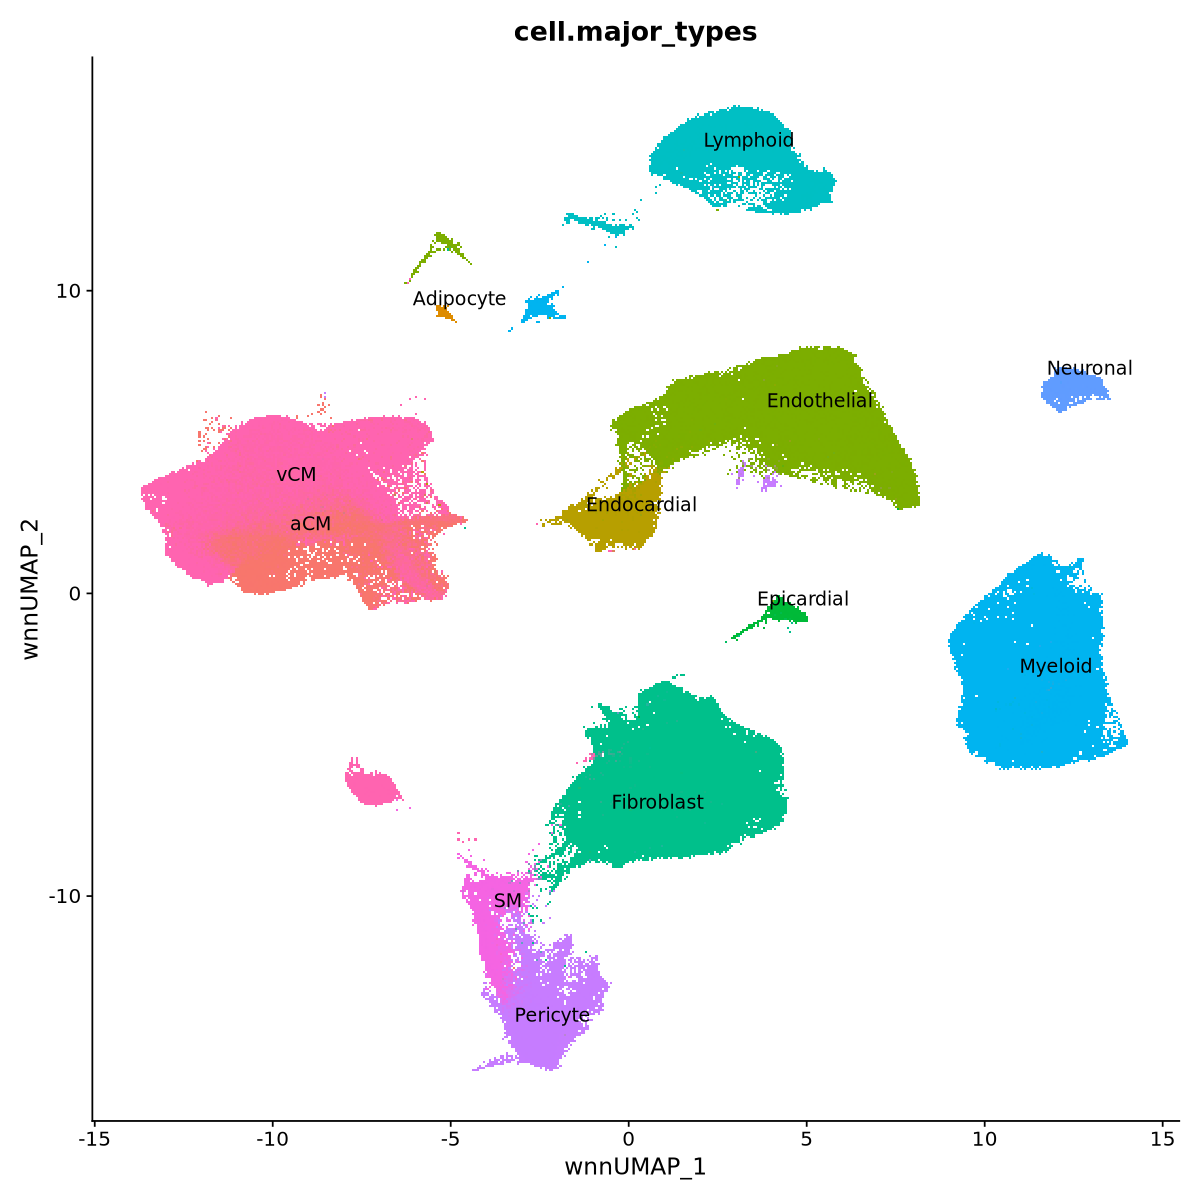

In [47]:
# visualize the results for individual objects
options(repr.plot.width=10, repr.plot.height=10)
DimPlot(adata, reduction = 'umap.wnn',
        group.by = 'cell.major_types', label=TRUE, repel=TRUE, order = FALSE) + NoLegend()

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



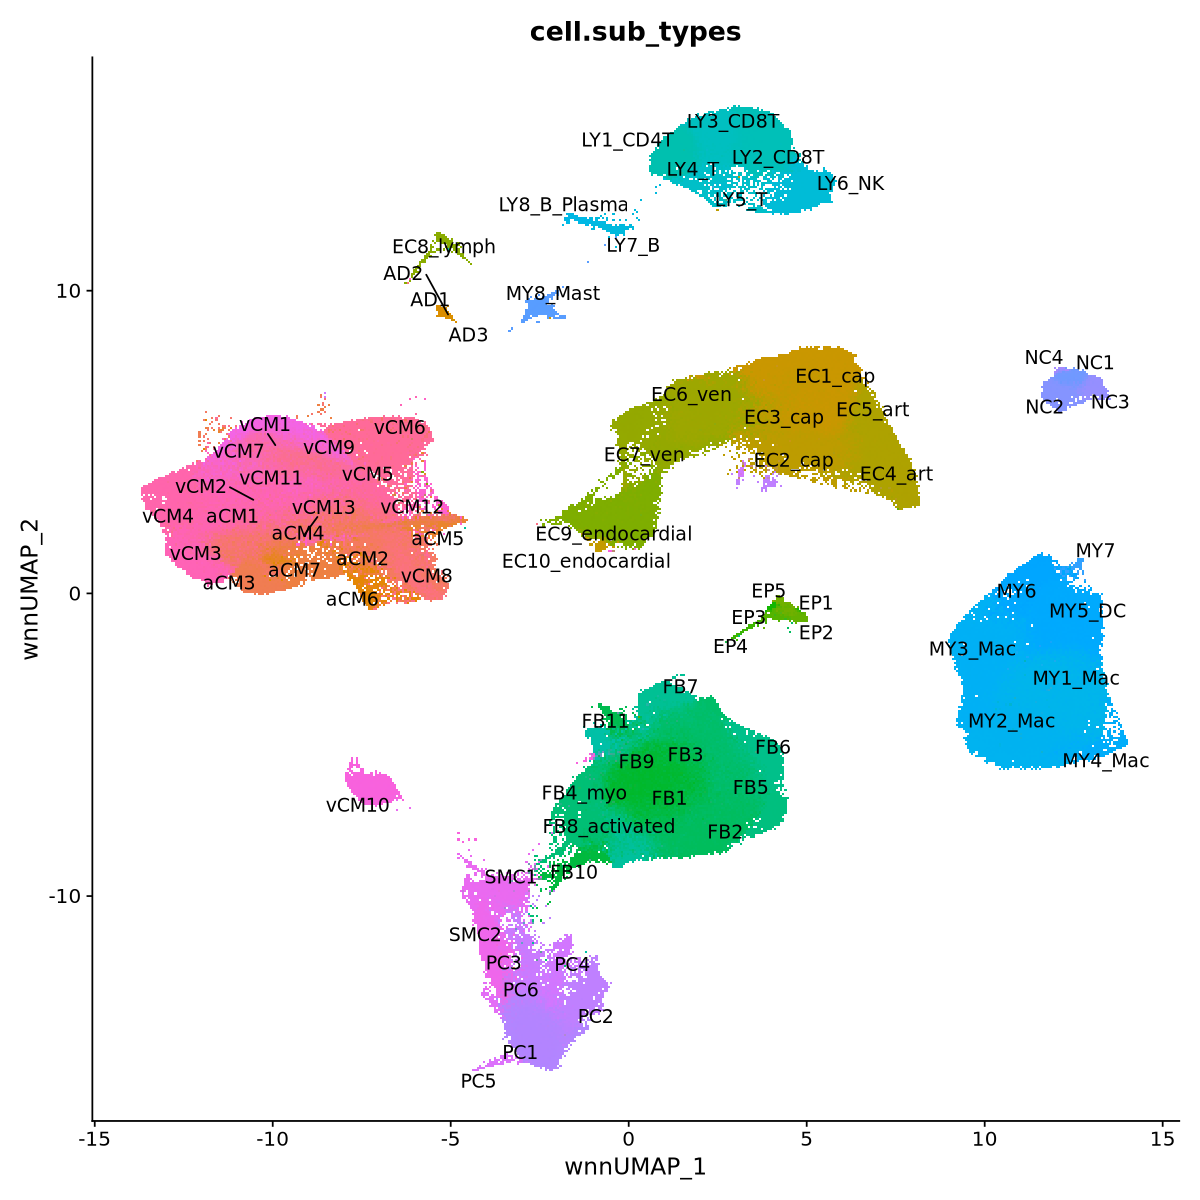

In [48]:
# visualize the results for individual objects
options(repr.plot.width=10, repr.plot.height=10)
DimPlot(adata, reduction = 'umap.wnn',
        group.by = 'cell.sub_types', label=TRUE, repel=TRUE, order = FALSE) + NoLegend()

In [40]:
log_print(" Saving data")
saveRDS(adata, in.dir)
log_print(paste("Done"))

[1] " Saving data"
[1] "Done"


In [49]:
adata

An object of class Seurat 
392510 features across 329255 samples within 4 assays 
Active assay: ATAC (285498 features, 285498 variable features)
 2 layers present: counts, data
 3 other assays present: RNA, RNA_raw, SCT
 7 dimensional reductions calculated: pca, harmony.rna, umap.rna, lsi, harmony.atac, umap.atac, umap.wnn

# Call peaks by major celltypes

In [50]:
peaks.dir = "/nfs/lab/projects/mega_heart/FNIH/multiome/Analysis/1_preprocessing/PeakCalling/2_PeaksMap_Peakcalls/"

In [51]:
log_print(paste0("Calling peaks"))
peaks <- CallPeaks(
    object = adata,
    assay = "ATAC",
    group.by = "cell.major_types",
    macs2.path = '/home/luca/.local/bin/macs2',
    broad = FALSE,
    format = "BED", 
    combine.peaks = FALSE,
    outdir = peaks.dir,
    cleanup = FALSE,
    verbose = TRUE)
log_print(paste0("Done"))

[1] "Calling peaks"


Processing file /nfs/lab/projects/mega_heart/FNIH/multiome/Analysis/1_preprocessing/merged.atac_fragments.tsv.gz






[1] "Done"


# Unify peaks

## Shrink down to 300

In [52]:
files = list.files(peaks.dir, pattern = "peaks.xls")

In [53]:
# THIS OPTION IS NEEDED ELSE BEDOPS WILL GET MAD
options(scipen = 999)

In [54]:
width.max = 300

In [55]:
log_print(paste0("shrinking peaks"))
for (i in seq_along(files)){
    peaks.use = read.table(paste0(peaks.dir, files[i]),
           header = TRUE)
    celltype = str_split(peaks.use$name[1], "_peak_")[[1]][1]
    # Shrink peaks around the summit
    shrunkpeaks <- peaks.use %>%
        dplyr::mutate(start = ifelse(length > width.max, abs_summit - width.max/2, start),
                end = ifelse(length > width.max, abs_summit + width.max/2, end),
                length = ifelse(length > width.max, width.max, length)) %>%
    mutate(start = ifelse(start < 0, 1, start))
    message("Number of negative 'starts' -> ", nrow(dplyr::filter(shrunkpeaks, start < 0)))
    # Save narrow peak file
    write.table(shrunkpeaks, paste0(peaks.dir, celltype, "_shrunk.narrowPeak"), 
                sep = '\t', row.names = FALSE, quote=FALSE)
    # Save bed file formatted for bedops
    shrunkpeaks = shrunkpeaks %>%
        dplyr::select(chr, start, end, name, pileup)
    # Save narrow peak file
    write.table(shrunkpeaks, paste0(peaks.dir, celltype, "_shrunk.bed"), 
                sep = '\t', row.names = FALSE, col.names = FALSE, quote=FALSE)
    message("Saved peaks for: ", celltype)    
}
log_print(paste0("Done"))

[1] "shrinking peaks"


Number of negative 'starts' -> 0

Saved peaks for: aCM

Number of negative 'starts' -> 0

Saved peaks for: Adipocyte

Number of negative 'starts' -> 0

Saved peaks for: Endocardial

Number of negative 'starts' -> 0

Saved peaks for: Endothelial

Number of negative 'starts' -> 0

Saved peaks for: Epicardial

Number of negative 'starts' -> 0

Saved peaks for: Fibroblast

Number of negative 'starts' -> 0

Saved peaks for: Lymphoid

Number of negative 'starts' -> 0

Saved peaks for: Myeloid

Number of negative 'starts' -> 0

Saved peaks for: Neuronal

Number of negative 'starts' -> 0

Saved peaks for: Pericyte

Number of negative 'starts' -> 0

Saved peaks for: SM

Number of negative 'starts' -> 0

Saved peaks for: vCM



[1] "Done"


## Cluster and pick tallest peak

In [56]:
## Setup folders
indir = peaks.dir
tmpdir = paste0(peaks.dir, "TMP/")
outdir = paste0(peaks.dir, "unified_peaks/")

dir.create(tmpdir)
dir.create(outdir)

In [57]:
# Then open a screen and start the copy and paste process for bedops

In [ ]:
conda activate /home/luca/.conda/envs/macs3

In [58]:
indir
tmpdir
outdir

[1] "/nfs/lab/projects/mega_heart/FNIH/multiome/Analysis/1_preprocessing/PeakCalling/2_PeaksMap_Peakcalls/"

[1] "/nfs/lab/projects/mega_heart/FNIH/multiome/Analysis/1_preprocessing/PeakCalling/2_PeaksMap_Peakcalls/TMP/"

[1] "/nfs/lab/projects/mega_heart/FNIH/multiome/Analysis/1_preprocessing/PeakCalling/2_PeaksMap_Peakcalls/unified_peaks/"

In [ ]:
#!/bin/bash
##Define directory locations
#input directory must contain files with .bed extension to be analyzed
indir=/nfs/lab/projects/mega_heart/FNIH/multiome/Analysis/1_preprocessing/PeakCalling/2_PeaksMap_Peakcalls/
tmpdir=/nfs/lab/projects/mega_heart/FNIH/multiome/Analysis/1_preprocessing/PeakCalling/2_PeaksMap_Peakcalls/TMP/
outdir=/nfs/lab/projects/mega_heart/FNIH/multiome/Analysis/1_preprocessing/PeakCalling/2_PeaksMap_Peakcalls/unified_peaks/

#Name your output
outfile=FNIH_MultiomePeaks.bed

#Initialize iteration, output and stop clause
touch ${outdir}/${outfile}
iters=1
stop=0

#Make tmp directory
if [ ! -d $tmpdir ]; then
        mkdir $tmpdir;
fi

#Merge all bedfiles into one file
#NEED TO CHANGE THIS IF YOU HAVE MULTIPLE BED FILES IN HERE YOU DON'T WANT TO ANALYZE
bedops -u ${indir}/*_shrunk.bed > $tmpdir/tmp.bed

while [ $stop == 0 ]
do 
        echo "merge steps..."
        #Merge overlapping peaks in this input file
        bedops -m $tmpdir/tmp.bed > ${tmpdir}/tmpmerge.bed

        #Find the peak in each merged cluster with the highest read
        bedmap --max-element $tmpdir/tmpmerge.bed $tmpdir/tmp.bed \
                | sort-bed - \
                > $tmpdir/${iters}.bed \

                #Add recent iteration to final bed
        #Used to write each of these outputs out individually and then merge but it takes up WAY too much space
        cat ${outdir}/${outfile} $tmpdir/${iters}.bed > ${outdir}/tmp && mv ${outdir}/tmp ${outdir}/${outfile}

        num=$(wc -l $tmpdir/${iters}.bed | awk '{print $1}')
        echo "Adding ${num} elements"
        #Find which peaks don't overlap the previously defined "true" peak for each merged cluster
        bedops -n 1 $tmpdir/tmp.bed $tmpdir/${iters}.bed \
                > $tmpdir/tmp2.bed
        #Make these peaks your new starting file
        mv $tmpdir/tmp2.bed $tmpdir/tmp.bed
        #Clean up tmp file (if I let it go this tmp directory gets MASSIVE AF)
        rm $tmpdir/${iters}.bed

        #Checks if the file is empty
        if [ $num -lt 1 ]
        then
                stop=1
        fi

        ((iters++))
done

#Add headers back in
echo -e "Chr\tStart\tEnd\tPeakID\tPileup_Score" > header && cat header ${outdir}/${outfile} > tmp && mv tmp ${outdir}/${outfile}

rm -r $tmpdir header

# Add peaklist to the object

Peaks Detected: 511239

  - Second pileup_score quantile: 57

  - Post-filters: 381829

  - Only on standard Chromosomes: 381578

  - After blacklist exclusion: 381165



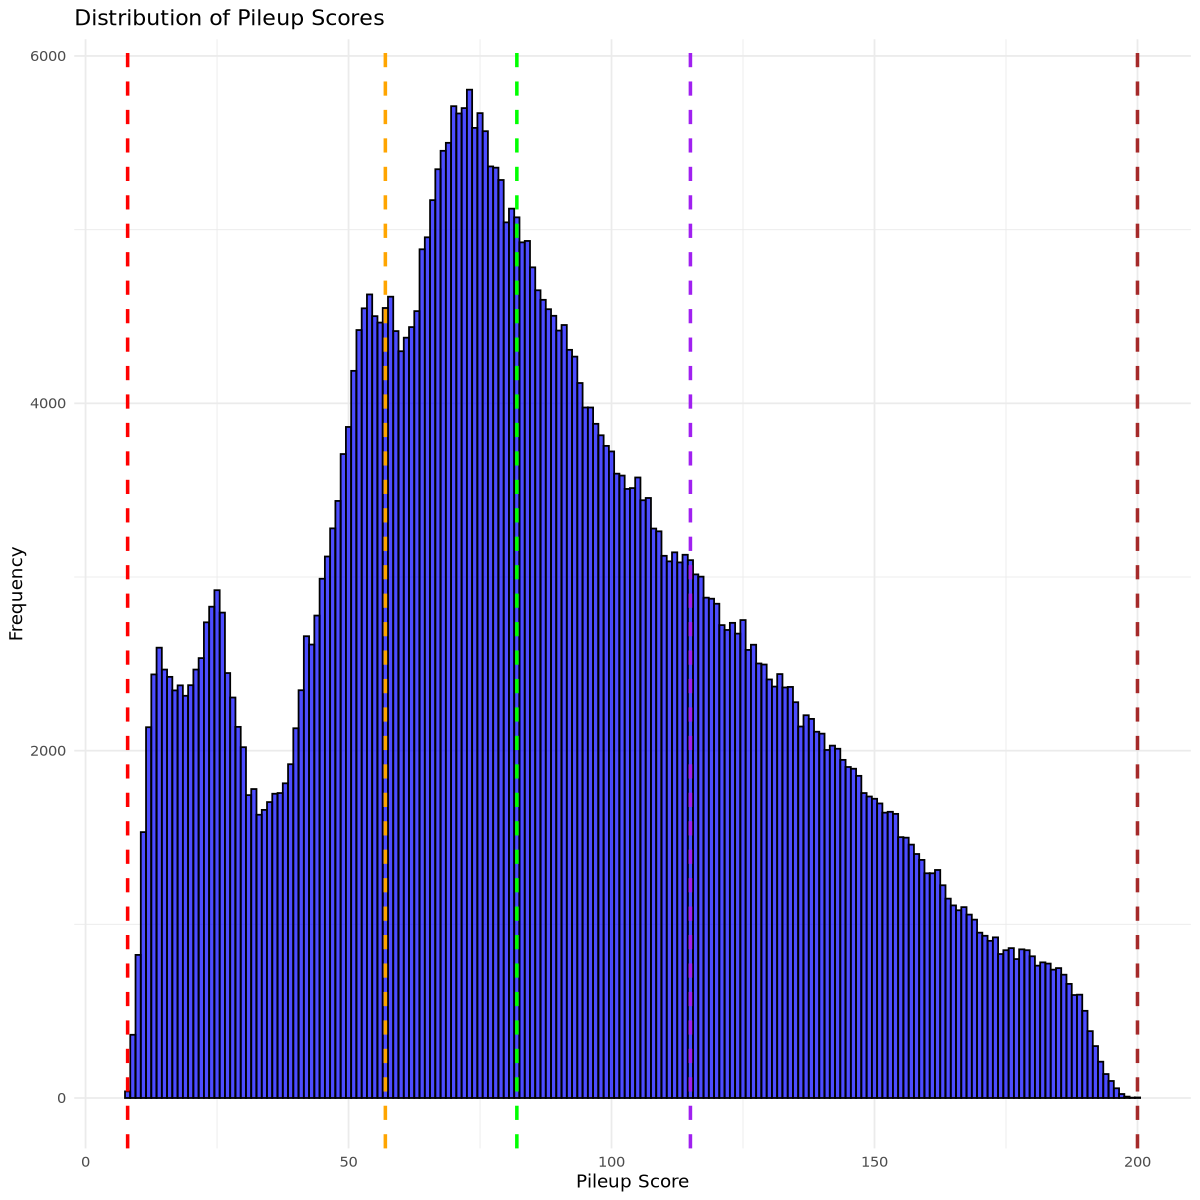

In [59]:
# load windows or peaks:
peaks.dir = '/nfs/lab/projects/mega_heart/FNIH/multiome/Analysis/1_preprocessing/PeakCalling/2_PeaksMap_Peakcalls/unified_peaks/FNIH_MultiomePeaks.bed'
peaks = read.table(peaks.dir, header = TRUE)
message("Peaks Detected: ", nrow(peaks))

# Calculate the quantiles
quantiles <- quantile(peaks$Pileup_Score)

# Create the histogram
ggplot(peaks, aes(x = Pileup_Score)) +
  geom_histogram(binwidth = 1, fill = "blue", color = "black", alpha = 0.7) +
  labs(title = "Distribution of Pileup Scores",
       x = "Pileup Score",
       y = "Frequency") +
  theme_minimal() +
  geom_vline(aes(xintercept = quantiles[1]), color = "red", linetype = "dashed", size = 1) +
  geom_vline(aes(xintercept = quantiles[2]), color = "orange", linetype = "dashed", size = 1) +
  geom_vline(aes(xintercept = quantiles[3]), color = "green", linetype = "dashed", size = 1) +
  geom_vline(aes(xintercept = quantiles[4]), color = "purple", linetype = "dashed", size = 1) +
  geom_vline(aes(xintercept = quantiles[5]), color = "brown", linetype = "dashed", size = 1)

message("  - Second pileup_score quantile: ", quantiles[2])
peaks = dplyr::filter(peaks, Pileup_Score > quantiles[2])
peaks = paste0(peaks$Chr, ":", peaks$Start, "-", peaks$End)
message("  - Post-filters: ", length(peaks))
peaks = StringToGRanges(peaks, sep = c(":", "-"))
# remove peaks on nonstandard chromosomes and in genomic blacklist regions
peaks <- keepStandardChromosomes(peaks, pruning.mode = "coarse")
message("  - Only on standard Chromosomes: ", length(peaks))
peaks <- subsetByOverlaps(x = peaks, ranges = blacklist_hg38_unified, invert = TRUE)
message("  - After blacklist exclusion: ", length(peaks))

#save peak list for future use

In [60]:
file = "/nfs/lab/projects/mega_heart/FNIH/multiome/Analysis/1_preprocessing/PeakCalling/2_PeaksMap_Peakcalls/unified_peaks/FNIH_MultiomePeaks_filt.bed"
write.table(as.data.frame(peaks), file, col.names = FALSE, row.names = FALSE, quote = FALSE)

In [61]:
adata

An object of class Seurat 
392510 features across 329255 samples within 4 assays 
Active assay: ATAC (285498 features, 285498 variable features)
 2 layers present: counts, data
 3 other assays present: RNA, RNA_raw, SCT
 7 dimensional reductions calculated: pca, harmony.rna, umap.rna, lsi, harmony.atac, umap.atac, umap.wnn

In [64]:
log_print(paste("Creating LFM"))
# Create a peak/cell count matrix
atac_counts <- FeatureMatrix(fragments = adata@assays$ATAC@fragments,
                             features = peaks,
                             cells = colnames(adata@assays$RNA))

[1] "Creating LFM"


Extracting reads overlapping genomic regions



In [65]:
head(atac_counts)
dim(atac_counts)

  [[ suppressing 34 column names 'QY_2193_1_2_QY_2192_1_2_AAACAGCCAACTAGGG-1', 'QY_2193_1_2_QY_2192_1_2_AAACAGCCACTTACAG-1', 'QY_2193_1_2_QY_2192_1_2_AAACAGCCAGTTTGTG-1' ... ]]



6 x 329255 sparse Matrix of class "dgCMatrix"
                                                                              
chr1-9955-10255    . . . . . . . . . 1 . . . . . 1 . . . . . . . . . . . . . .
chr1-16002-16302   . . . . . . . . . . . . . . . . . . . 1 . 1 . . . . . . . .
chr1-17244-17544   . . . . . . . . . . . . . . . 1 . . . . . . . . . . . . . .
chr1-181260-181560 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
chr1-182588-182859 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
chr1-183547-183847 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
                                 
chr1-9955-10255    . . . 1 ......
chr1-16002-16302   . . . . ......
chr1-17244-17544   . . . . ......
chr1-181260-181560 . . . . ......
chr1-182588-182859 . . . . ......
chr1-183547-183847 . . . . ......

 .....suppressing 329221 columns in show(); maybe adjust options(max.print=, width=)
 ..............................

[1] 381165 329255

In [66]:
log_print(paste("Creating chrom_assay"))
gc(reset = TRUE)
chrom_assay <- CreateChromatinAssay(counts=atac_counts,
                                                     sep = c(':', '-'),
                                                     genome = seq.info,
                                                     fragments = adata@assays$ATAC@fragments,
                                                     min.cells = 10,
                                                     min.features = 0,
                                                     annotation = annotations)

[1] "Creating chrom_assay"


,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,15489022,827.3,32746164,1748.9,15489022,827.3
Vcells,11585024131,88386.8,23824141542,181763.8,11585024131,88386.8


In [67]:
log_print(paste("Find variable features"))
gc(reset = TRUE)
# Find most variable features
chrom_assay <- FindVariableFeatures(object = chrom_assay, selection.method = "vst")
# Pull variance stats
hvw_stats <- HVFInfo(object = chrom_assay, method = "vst")

[1] "Find variable features"


,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,15498643,827.8,32746164,1748.9,15498643,827.8
Vcells,11586465625,88397.8,23824141542,181763.8,11586465625,88397.8


subsetting for most variable features: 285873



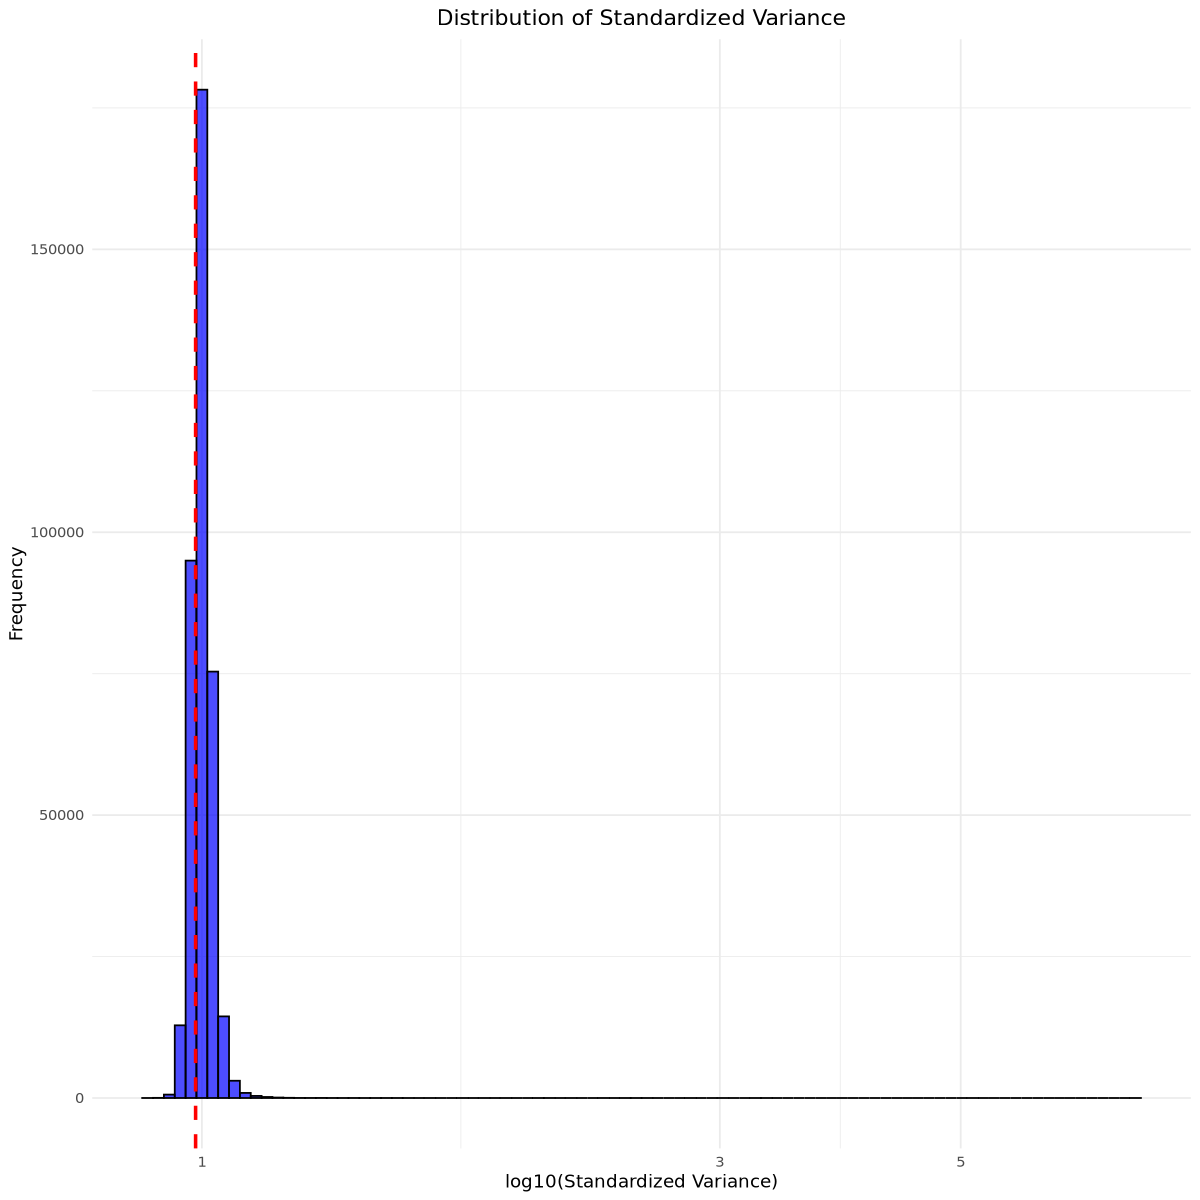

In [68]:
# Calculate a reasonable threshold (for example, the second quantile of variance)
threshold <- quantile(hvw_stats$variance.standardized, 0.25)

# Create the histogram with a better bin width and log scale
ggplot(hvw_stats, aes(x = variance.standardized)) +
  geom_histogram(binwidth = 0.01, fill = "blue", color = "black", alpha = 0.7) +
  labs(title = "Distribution of Standardized Variance",
       x = "log10(Standardized Variance)",
       y = "Frequency") +
  theme_minimal() +
  geom_vline(aes(xintercept = threshold), color = "red", linetype = "dashed", size = 1) +
  scale_x_log10() +
  theme(plot.title = element_text(hjust = 0.5))

message("subsetting for most variable features: ", 
        nrow(dplyr::filter(hvw_stats, variance.standardized > threshold)))
# Subset the chromatin assay
selected_features <- rownames(hvw_stats[hvw_stats$variance.standardized > threshold, ])

In [69]:
chrom_assay_subset = subset(chrom_assay, features = selected_features)

In [70]:
chrom_assay
chrom_assay_subset

ChromatinAssay data with 381165 features for 329255 cells
Variable features: 2000 
Genome: hg38 
Annotation present: TRUE 
Motifs present: FALSE 
Fragment files: 1 

ChromatinAssay data with 285873 features for 329255 cells
Variable features: 2000 
Genome: hg38 
Annotation present: TRUE 
Motifs present: FALSE 
Fragment files: 1 

In [71]:
adata@assays$ATAC

ChromatinAssay data with 285498 features for 329255 cells
Variable features: 285498 
Genome: hg38 
Annotation present: TRUE 
Motifs present: FALSE 
Fragment files: 1 

In [72]:
log_print(paste("attach peaks based ATAC assay"))
DefaultAssay(adata) <- 'RNA'
adata[['ATAC']] <- NULL
adata[['ATAC']] <- chrom_assay_subset
# Remove assays we don't need
adata[['ATAC_windows']] = NULL

[1] "attach peaks based ATAC assay"


In [73]:
# Double check annotation
## adata$cell.major_types OK
# adata$cell.sub_types = adata$cell.sub_types_chamber
## adata$cell.sub_types_disease OK
# adata$cell.sub_types_chamber = NULL

In [74]:
# ATAC analysis
log_print("Starting ATAC analysis")
DefaultAssay(adata) <- 'ATAC'
log_print("  - RunTFIDF")
adata <- RunTFIDF(adata)
adata <- FindTopFeatures(adata, min.cutoff='q0', verbose=FALSE)
log_print("  - RunSVD")
adata <- RunSVD(adata)

[1] "Starting ATAC analysis"
[1] "  - RunTFIDF"


Performing TF-IDF normalization



[1] "  - RunSVD"


Running SVD

Scaling cell embeddings



In [75]:
# Save peaks for future use
peaks = rownames(adata@assays$ATAC)
file = "/nfs/lab/projects/mega_heart/FNIH/multiome/Analysis/1_preprocessing/PeakCalling/2_PeaksMap_Peakcalls/unified_peaks/FNIH_MultiomePeaks_FiltVariable.bed"
write.table(as.data.frame(peaks), file, col.names = FALSE, row.names = FALSE, quote = FALSE)

In [76]:
in.dir

[1] "/nfs/lab/projects/mega_heart/FNIH/multiome/Analysis/1_preprocessing/LV_RV_LA_RA.multiome.mrg.filt.MTless.silQC.curated.peaks.rds"

In [77]:
log_print(" Saving data")
saveRDS(adata, in.dir)
log_print(paste("Done"))

[1] " Saving data"
[1] "Done"


In [78]:
adata

An object of class Seurat 
392885 features across 329255 samples within 4 assays 
Active assay: ATAC (285873 features, 285873 variable features)
 2 layers present: counts, data
 3 other assays present: RNA, RNA_raw, SCT
 7 dimensional reductions calculated: pca, harmony.rna, umap.rna, lsi, harmony.atac, umap.atac, umap.wnn

# Re-label LV - reference

In [103]:
in.dir = reference.LV.dir

In [104]:
log_print(" Loading data")
adata = readRDS(in.dir)
log_print(paste("Done"))

[1] " Loading data"
[1] "Done"


In [123]:
# Subset the metadata to include only the cells present in adata
metadata_subset <- metadata[metadata$X %in% colnames(adata), , drop = FALSE]
rownames(metadata_subset) <- metadata_subset$X
# Add the metadata to the Seurat object
adata <- AddMetaData(object = adata, metadata = metadata_subset[,"cell.major_types", drop = FALSE])

In [124]:
# Create a metadata label for CMs
adata$cell.sub_types_chamber = adata$cell.sub_types
adata$cell.sub_types_chamber[adata$cell.sub_types_chamber == "CM" & adata$chamber == "LA"] <- "aCM"
adata$cell.sub_types_chamber[adata$cell.sub_types_chamber == "CM" & adata$chamber == "RA"] <- "aCM"
adata$cell.sub_types_chamber[adata$cell.sub_types_chamber == "CM" & adata$chamber == "LV"] <- "vCM"
adata$cell.sub_types_chamber[adata$cell.sub_types_chamber == "CM" & adata$chamber == "RV"] <- "vCM"

adata$chamber_major = adata$chamber
adata$chamber_major[adata$chamber == "LA"] <- "atria"
adata$chamber_major[adata$chamber == "RA"] <- "atria"
adata$chamber_major[adata$chamber == "LV"] <- "ventricle"
adata$chamber_major[adata$chamber == "RV"] <- "ventricle"

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



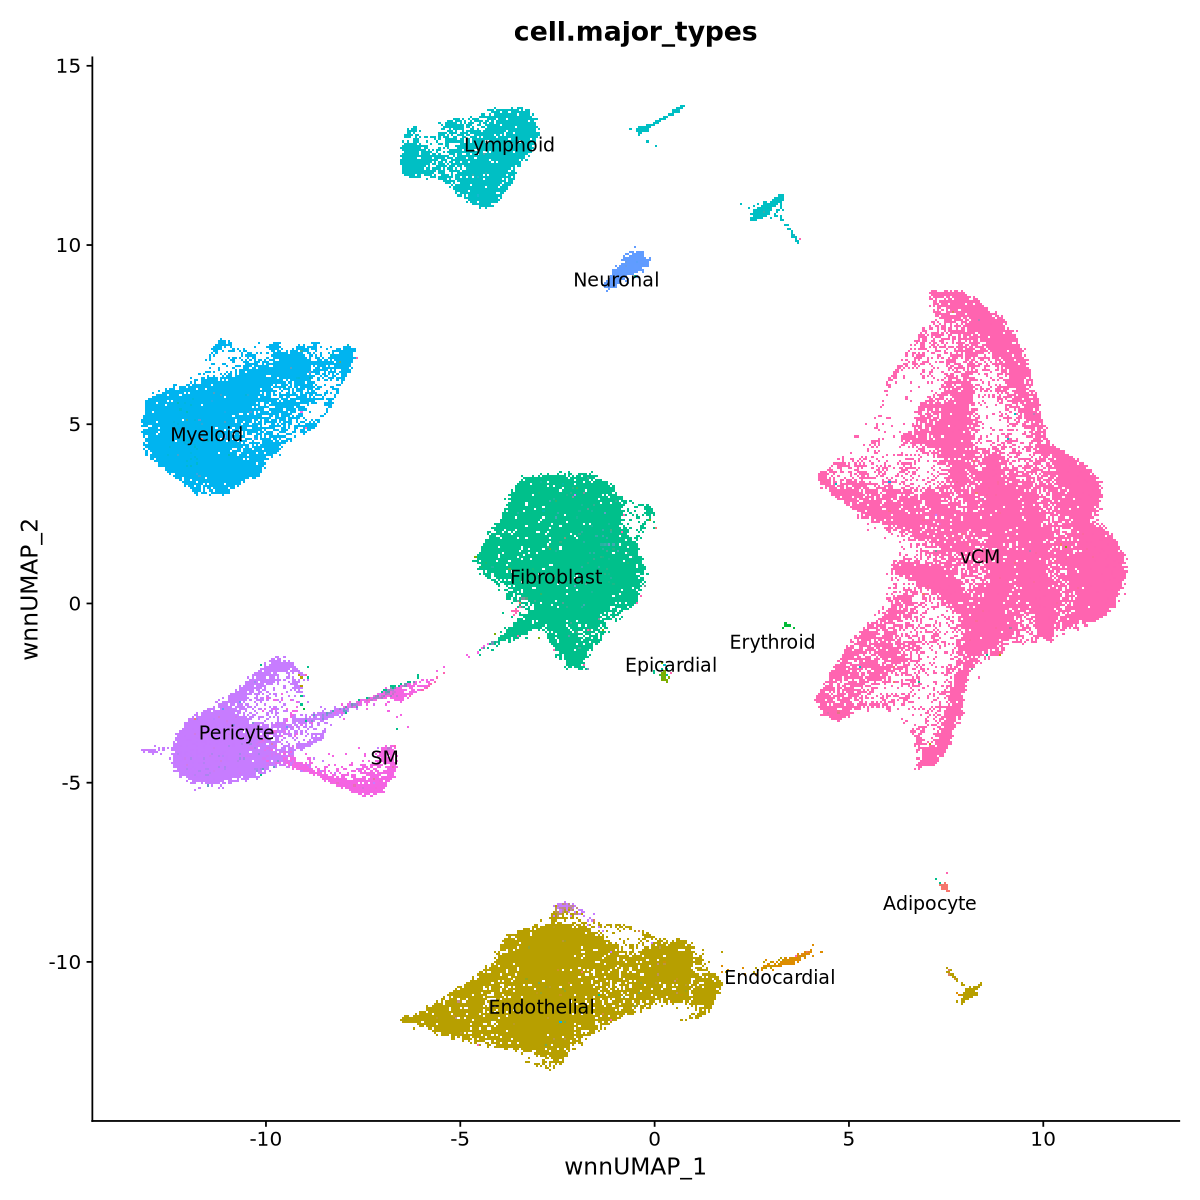

In [125]:
# visualize the results for individual objects
options(repr.plot.width=10, repr.plot.height=10)
DimPlot(adata, reduction = 'umap.wnn', 
        group.by = 'cell.major_types', label=TRUE, repel=TRUE) + NoLegend()

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



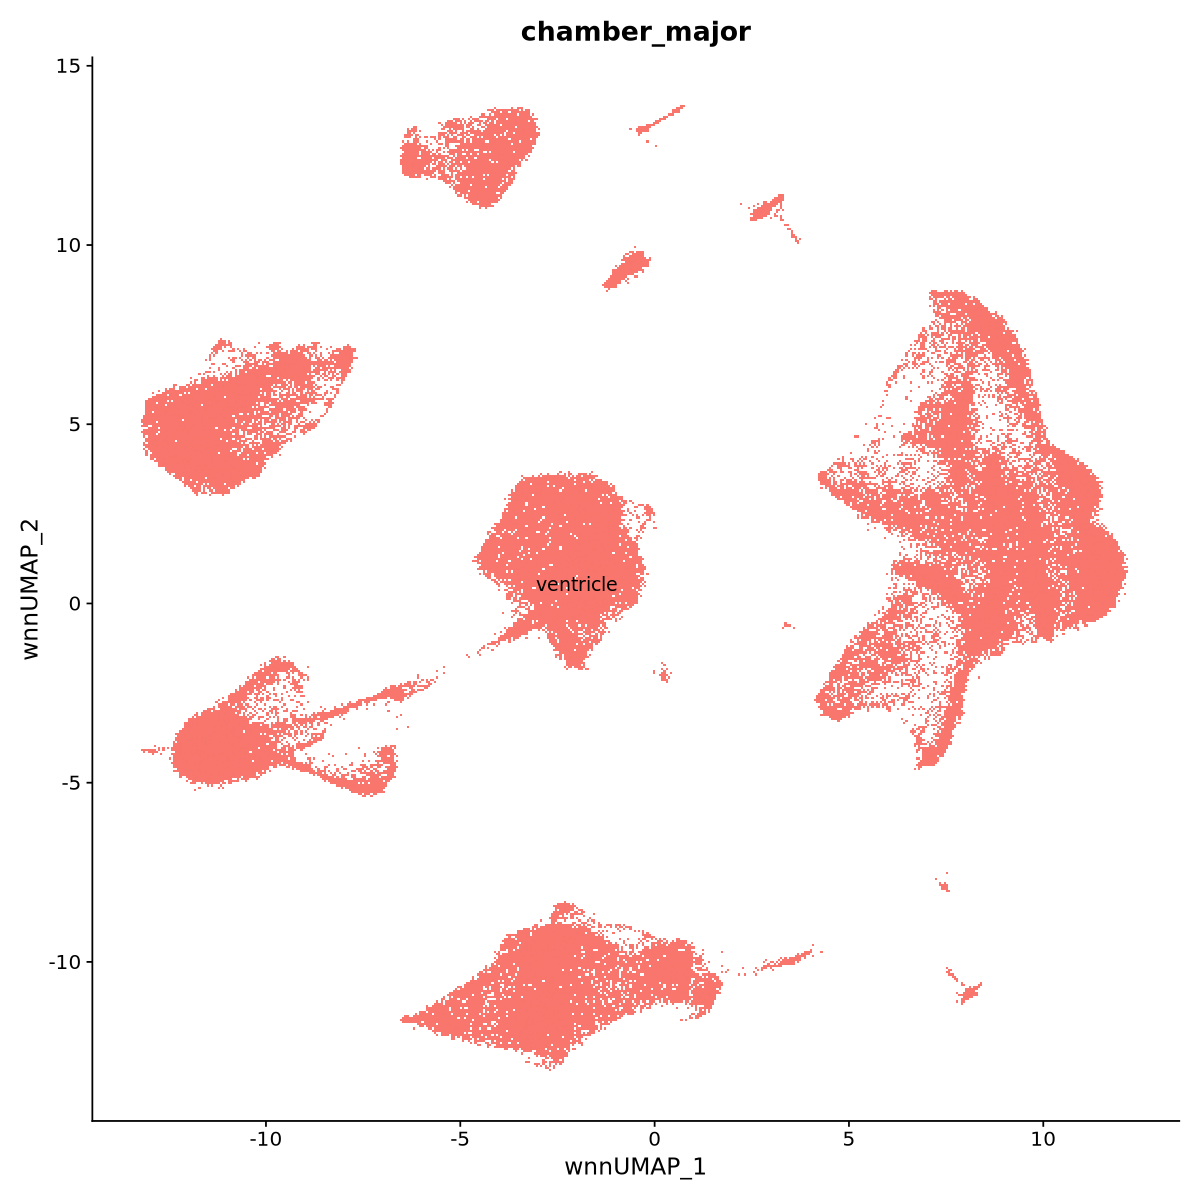

In [126]:
# visualize the results for individual objects
options(repr.plot.width=10, repr.plot.height=10)
DimPlot(adata, reduction = 'umap.wnn', 
        group.by = 'chamber_major', label=TRUE, repel=TRUE) + NoLegend()

In [128]:
peaks.dir = "/nfs/lab/projects/mega_heart/FNIH/multiome/Analysis/1_preprocessing/PeakCalling/3_PeaksMap_byChamber_PeakCalls/LV/"

log_print(paste0("Calling peaks"))
peaks <- CallPeaks(
    object = adata,
    assay = "ATAC",
    group.by = "cell.major_types",
    macs2.path = '/home/luca/.local/bin/macs2',
    broad = FALSE,
    format = "BED", 
    combine.peaks = FALSE,
    outdir = peaks.dir,
    cleanup = FALSE,
    verbose = TRUE)
log_print(paste0("Done"))

[1] "Calling peaks"


Processing file /nfs/lab/projects/mega_heart/FNIH/multiome/Analysis/1_preprocessing/merged.atac_fragments.tsv.gz






[1] "Done"


In [ ]:
file = "/nfs/lab/projects/mega_heart/FNIH/multiome/Analysis/1_preprocessing/PeakCalling/2_PeaksMap_Peakcalls/unified_peaks/FNIH_MultiomePeaks_FiltVariable.bed"
peaks = read.table(file)
peaks = peaks$V1
peaks = StringToGRanges(peaks, sep = c(":", "-"))
peaks

In [138]:
log_print(paste("Creating LFM"))
# Create a peak/cell count matrix
atac_counts <- FeatureMatrix(fragments = adata@assays$ATAC@fragments,
                             features = peaks,
                             cells = colnames(adata@assays$ATAC))
# Create adata.python
log_print(paste("Creating chrom_assay"))
suppressWarnings(chrom_assay <- CreateChromatinAssay(counts=atac_counts,
                                                     sep=c(':', '-'),
                                                     genome= seq.info,
                                                     fragments = adata@assays$ATAC@fragments,
                                                     min.cells=0,
                                                     min.features=0,
                                                     annotation=annotations))

[1] "Creating LFM"


Extracting reads overlapping genomic regions



[1] "Creating chrom_assay"


In [139]:
log_print(paste("attach peaks based ATAC assay"))
DefaultAssay(adata) <- 'RNA'
adata[['ATAC']] <- NULL
adata[['ATAC']] <- chrom_assay_subset
# Remove assays we don't need
adata[['ATAC_windows']] = NULL

# Double check annotation
## adata$cell.major_types OK
adata$cell.sub_types = adata$cell.sub_types_chamber
## adata$cell.sub_types_disease OK
adata$cell.sub_types_chamber = NULL

# ATAC analysis
log_print("Starting ATAC analysis")
DefaultAssay(adata) <- 'ATAC'
log_print("  - RunTFIDF")
adata <- RunTFIDF(adata)
adata <- FindTopFeatures(adata, min.cutoff='q0', verbose=FALSE)
log_print("  - RunSVD")
adata <- RunSVD(adata)

[1] "attach peaks based ATAC assay"


In [ ]:
log_print(" Saving data")
adata = saveRDS(adata, in.dir)
log_print(paste("Done"))

# Re-label RV - reference

In [140]:
in.dir = reference.RV.dir

In [141]:
log_print(" Loading data")
adata = readRDS(in.dir)
log_print(paste("Done"))

[1] " Loading data"
[1] "Done"


In [142]:
# Subset the metadata to include only the cells present in adata
metadata_subset <- metadata[metadata$X %in% colnames(adata), , drop = FALSE]
rownames(metadata_subset) <- metadata_subset$X
# Add the metadata to the Seurat object
adata <- AddMetaData(object = adata, metadata = metadata_subset[,"cell.major_types", drop = FALSE])


In [143]:
# Create a metadata label for CMs
adata$cell.sub_types_chamber = adata$cell.sub_types
adata$cell.sub_types_chamber[adata$cell.sub_types_chamber == "CM" & adata$chamber == "LA"] <- "aCM"
adata$cell.sub_types_chamber[adata$cell.sub_types_chamber == "CM" & adata$chamber == "RA"] <- "aCM"
adata$cell.sub_types_chamber[adata$cell.sub_types_chamber == "CM" & adata$chamber == "LV"] <- "vCM"
adata$cell.sub_types_chamber[adata$cell.sub_types_chamber == "CM" & adata$chamber == "RV"] <- "vCM"

adata$chamber_major = adata$chamber
adata$chamber_major[adata$chamber == "LA"] <- "atria"
adata$chamber_major[adata$chamber == "RA"] <- "atria"
adata$chamber_major[adata$chamber == "LV"] <- "ventricle"
adata$chamber_major[adata$chamber == "RV"] <- "ventricle"

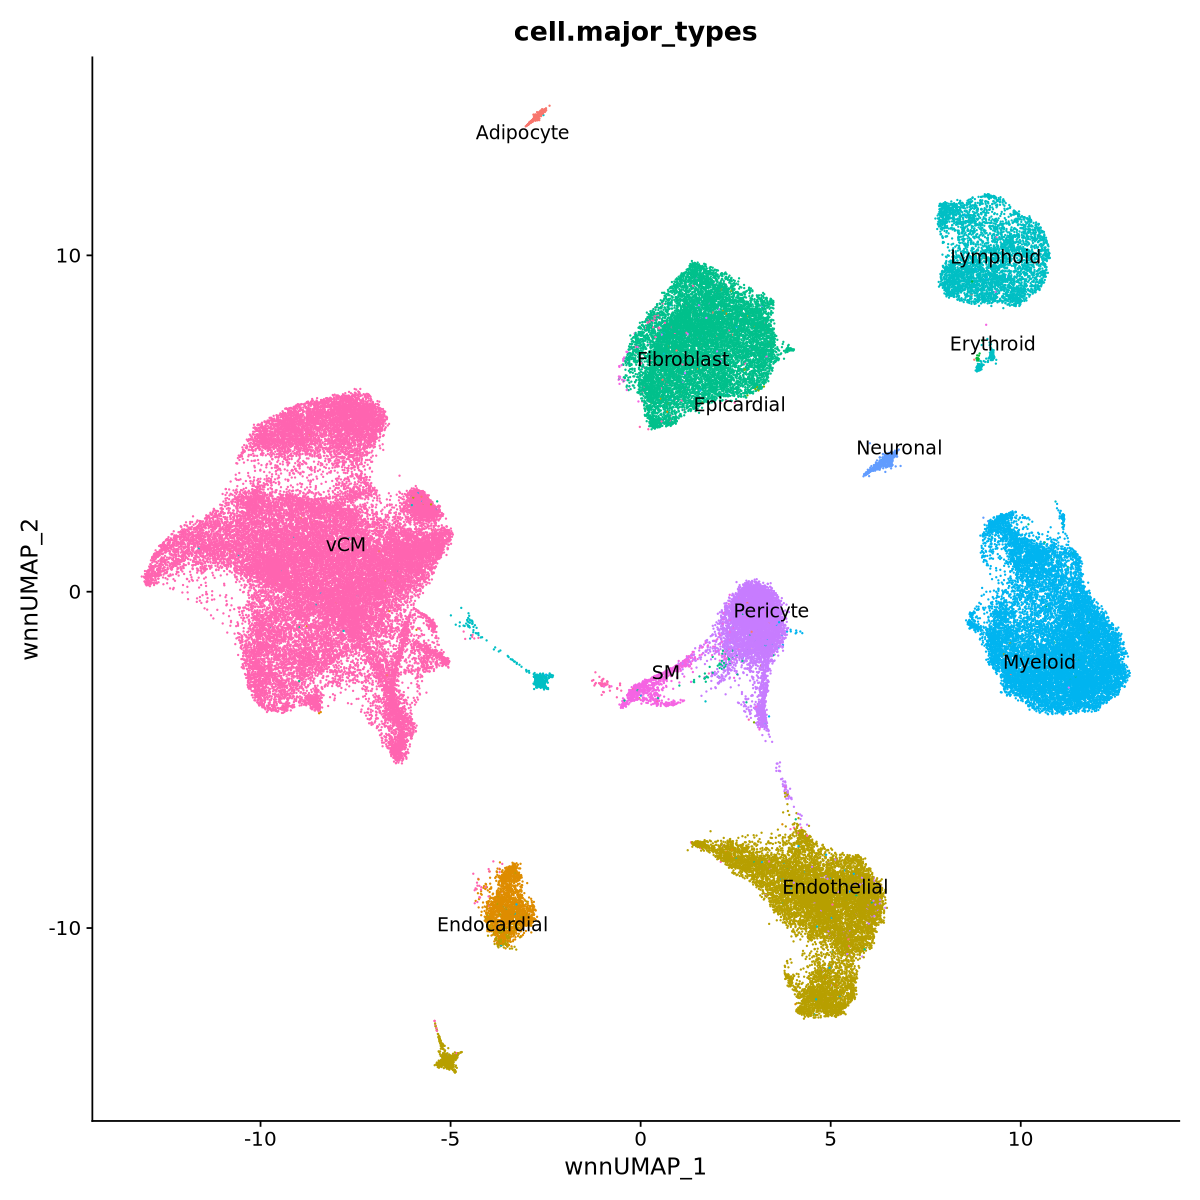

In [144]:
# visualize the results for individual objects
options(repr.plot.width=10, repr.plot.height=10)
DimPlot(adata, reduction = 'umap.wnn', 
        group.by = 'cell.major_types', label=TRUE, repel=TRUE) + NoLegend()

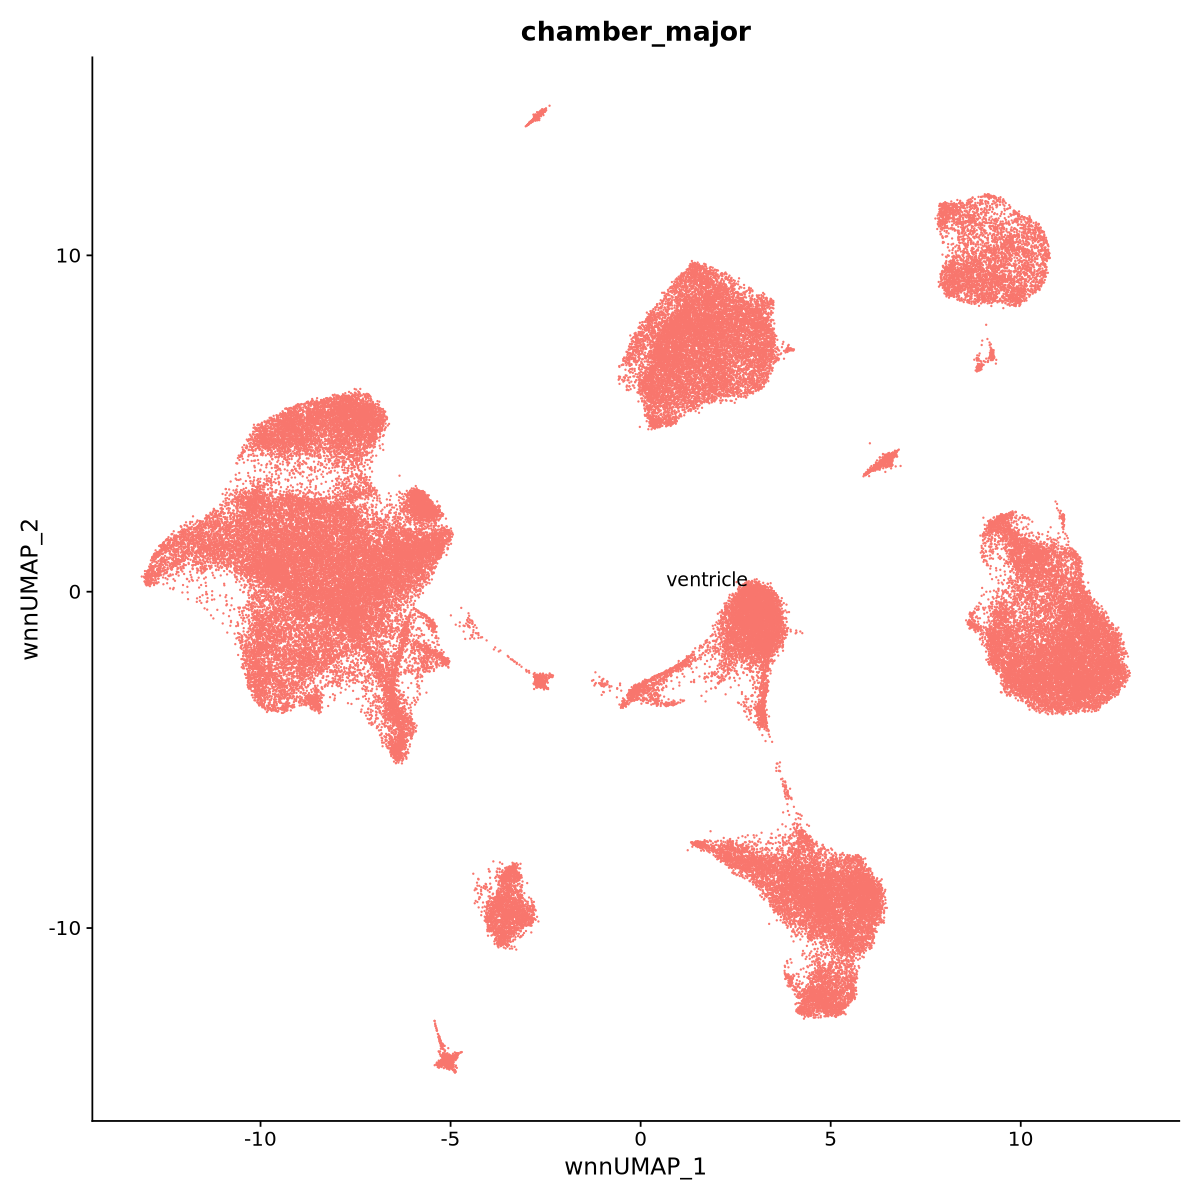

In [145]:
# visualize the results for individual objects
options(repr.plot.width=10, repr.plot.height=10)
DimPlot(adata, reduction = 'umap.wnn', 
        group.by = 'chamber_major', label=TRUE, repel=TRUE) + NoLegend()

In [146]:
peaks.dir = "/nfs/lab/projects/mega_heart/FNIH/multiome/Analysis/1_preprocessing/PeakCalling/3_PeaksMap_byChamber_PeakCalls/RV/"

log_print(paste0("Calling peaks"))
peaks <- CallPeaks(
    object = adata,
    assay = "ATAC",
    group.by = "cell.major_types",
    macs2.path = '/home/luca/.local/bin/macs2',
    broad = FALSE,
    format = "BED", 
    combine.peaks = FALSE,
    outdir = peaks.dir,
    cleanup = FALSE,
    verbose = TRUE)
log_print(paste0("Done"))


[1] "Calling peaks"


Processing file /nfs/lab/projects/mega_heart/FNIH/multiome/Analysis/1_preprocessing/merged.atac_fragments.tsv.gz






[1] "Done"


In [ ]:
file = "/nfs/lab/projects/mega_heart/FNIH/multiome/Analysis/1_preprocessing/PeakCalling/2_PeaksMap_Peakcalls/unified_peaks/FNIH_MultiomePeaks_FiltVariable.bed"
peaks = read.table(file)
peaks = peaks$V1
peaks = StringToGRanges(peaks, sep = c(":", "-"))
peaks

In [ ]:
log_print(paste("attach peaks based ATAC assay"))
DefaultAssay(adata) <- 'RNA'
adata[['ATAC']] <- NULL
adata[['ATAC']] <- chrom_assay_subset
# Remove assays we don't need
adata[['ATAC_windows']] = NULL

# Double check annotation
## adata$cell.major_types OK
adata$cell.sub_types = adata$cell.sub_types_chamber
## adata$cell.sub_types_disease OK
adata$cell.sub_types_chamber = NULL

# ATAC analysis
log_print("Starting ATAC analysis")
DefaultAssay(adata) <- 'ATAC'
log_print("  - RunTFIDF")
adata <- RunTFIDF(adata)
adata <- FindTopFeatures(adata, min.cutoff='q0', verbose=FALSE)
log_print("  - RunSVD")
adata <- RunSVD(adata)

In [ ]:
log_print(" Saving data")
adata = saveRDS(adata, in.dir)
log_print(paste("Done"))

# Re-label LA - reference

In [147]:
in.dir = reference.LA.dir

In [148]:
log_print(" Loading data")
adata = readRDS(in.dir)
log_print(paste("Done"))

[1] " Loading data"
[1] "Done"


In [149]:
# Subset the metadata to include only the cells present in adata
metadata_subset <- metadata[metadata$X %in% colnames(adata), , drop = FALSE]
rownames(metadata_subset) <- metadata_subset$X
# Add the metadata to the Seurat object
adata <- AddMetaData(object = adata, metadata = metadata_subset[,"cell.major_types", drop = FALSE])


In [150]:
# Create a metadata label for CMs
adata$cell.sub_types_chamber = adata$cell.sub_types
adata$cell.sub_types_chamber[adata$cell.sub_types_chamber == "CM" & adata$chamber == "LA"] <- "aCM"
adata$cell.sub_types_chamber[adata$cell.sub_types_chamber == "CM" & adata$chamber == "RA"] <- "aCM"
adata$cell.sub_types_chamber[adata$cell.sub_types_chamber == "CM" & adata$chamber == "LV"] <- "vCM"
adata$cell.sub_types_chamber[adata$cell.sub_types_chamber == "CM" & adata$chamber == "RV"] <- "vCM"

adata$chamber_major = adata$chamber
adata$chamber_major[adata$chamber == "LA"] <- "atria"
adata$chamber_major[adata$chamber == "RA"] <- "atria"
adata$chamber_major[adata$chamber == "LV"] <- "ventricle"
adata$chamber_major[adata$chamber == "RV"] <- "ventricle"

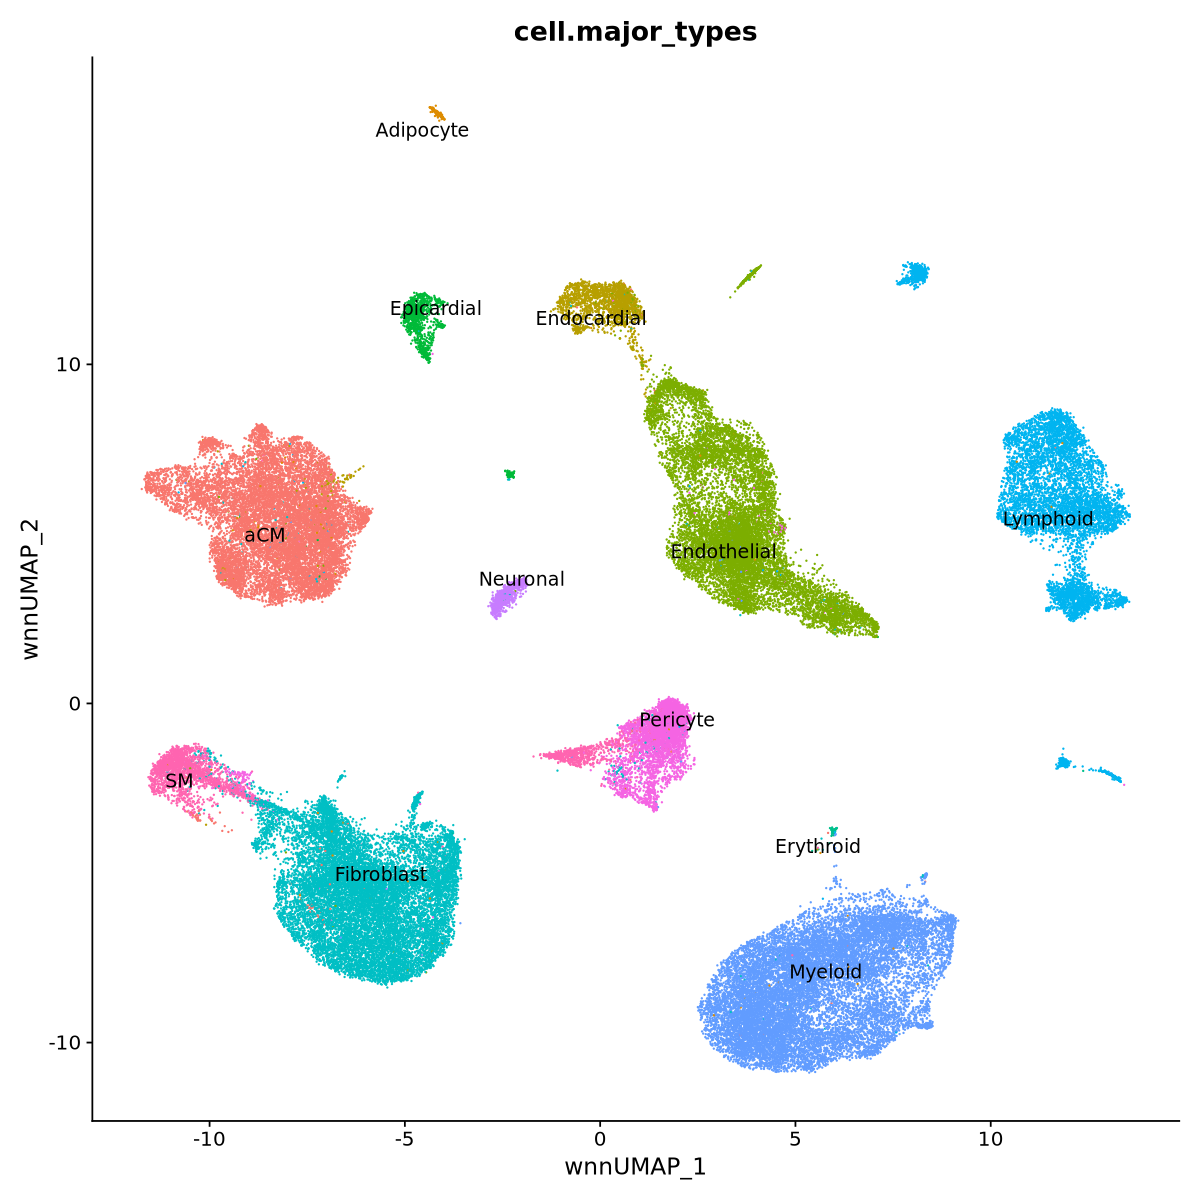

In [151]:
# visualize the results for individual objects
options(repr.plot.width=10, repr.plot.height=10)
DimPlot(adata, reduction = 'umap.wnn', 
        group.by = 'cell.major_types', label=TRUE, repel=TRUE) + NoLegend()

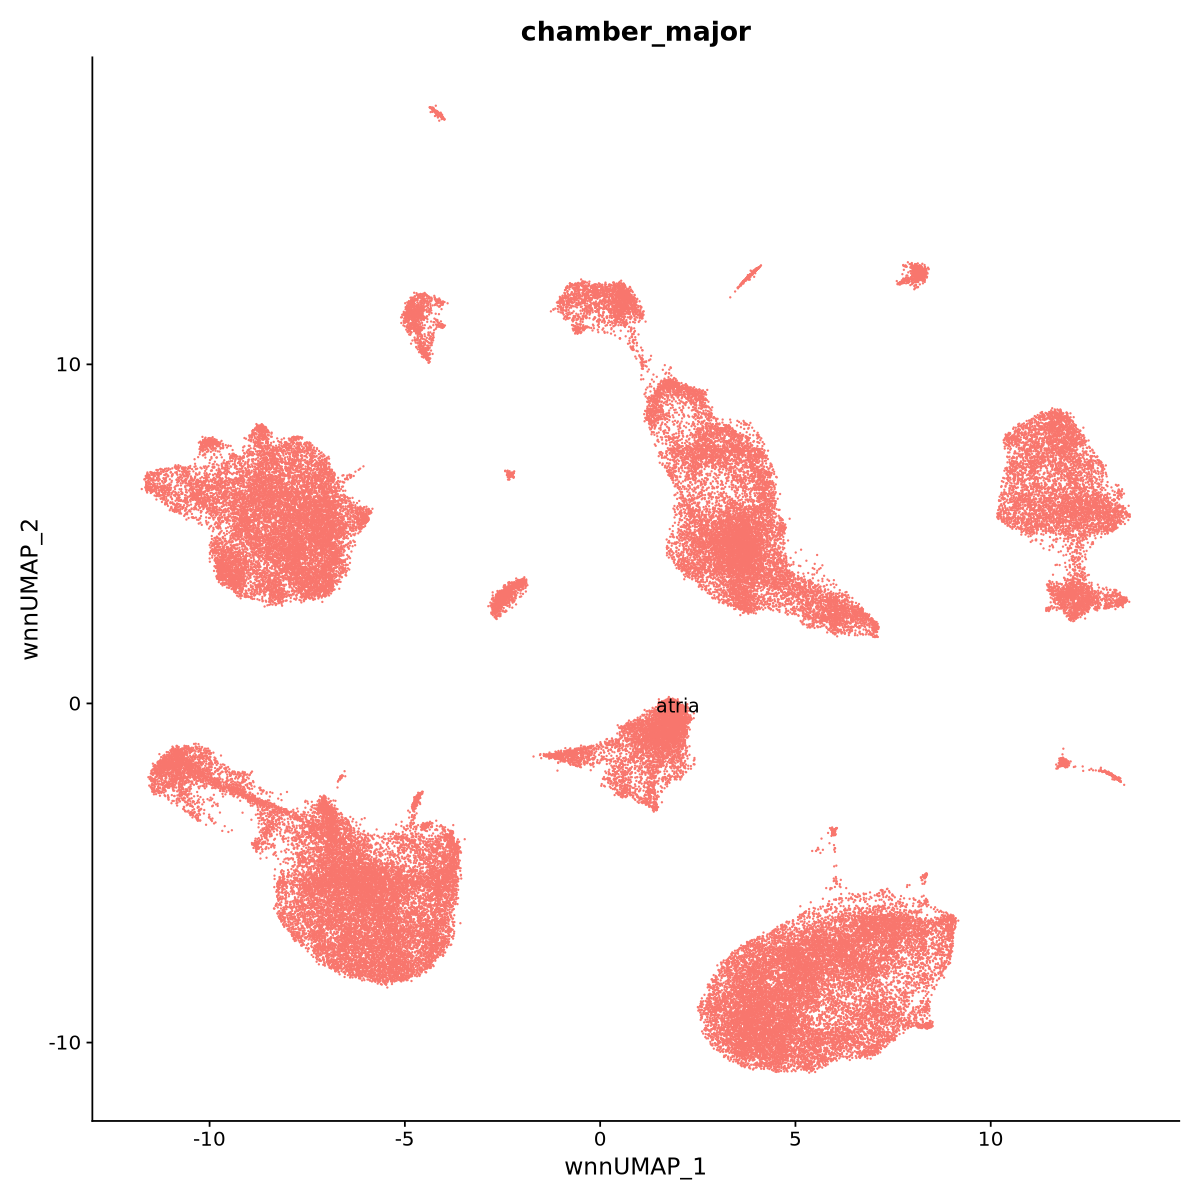

In [152]:
# visualize the results for individual objects
options(repr.plot.width=10, repr.plot.height=10)
DimPlot(adata, reduction = 'umap.wnn', 
        group.by = 'chamber_major', label=TRUE, repel=TRUE) + NoLegend()

In [153]:
peaks.dir = "/nfs/lab/projects/mega_heart/FNIH/multiome/Analysis/1_preprocessing/PeakCalling/3_PeaksMap_byChamber_PeakCalls/LA/"

log_print(paste0("Calling peaks"))
peaks <- CallPeaks(
    object = adata,
    assay = "ATAC",
    group.by = "cell.major_types",
    macs2.path = '/home/luca/.local/bin/macs2',
    broad = FALSE,
    format = "BED", 
    combine.peaks = FALSE,
    outdir = peaks.dir,
    cleanup = FALSE,
    verbose = TRUE)
log_print(paste0("Done"))


[1] "Calling peaks"


Processing file /nfs/lab/projects/mega_heart/FNIH/multiome/Analysis/1_preprocessing/merged.atac_fragments.tsv.gz






[1] "Done"


In [ ]:
file = "/nfs/lab/projects/mega_heart/FNIH/multiome/Analysis/1_preprocessing/PeakCalling/2_PeaksMap_Peakcalls/unified_peaks/FNIH_MultiomePeaks_FiltVariable.bed"
peaks = read.table(file)
peaks = peaks$V1
peaks = StringToGRanges(peaks, sep = c(":", "-"))
peaks

In [ ]:
log_print(paste("attach peaks based ATAC assay"))
DefaultAssay(adata) <- 'RNA'
adata[['ATAC']] <- NULL
adata[['ATAC']] <- chrom_assay_subset
# Remove assays we don't need
adata[['ATAC_windows']] = NULL

# Double check annotation
## adata$cell.major_types OK
adata$cell.sub_types = adata$cell.sub_types_chamber
## adata$cell.sub_types_disease OK
adata$cell.sub_types_chamber = NULL

# ATAC analysis
log_print("Starting ATAC analysis")
DefaultAssay(adata) <- 'ATAC'
log_print("  - RunTFIDF")
adata <- RunTFIDF(adata)
adata <- FindTopFeatures(adata, min.cutoff='q0', verbose=FALSE)
log_print("  - RunSVD")
adata <- RunSVD(adata)

In [ ]:
log_print(" Saving data")
adata = saveRDS(adata, in.dir)
log_print(paste("Done"))

# Re-label RA - reference

In [154]:
in.dir = reference.RA.dir

In [155]:
log_print(" Loading data")
adata = readRDS(in.dir)
log_print(paste("Done"))

[1] " Loading data"
[1] "Done"


In [156]:
# Subset the metadata to include only the cells present in adata
metadata_subset <- metadata[metadata$X %in% colnames(adata), , drop = FALSE]
rownames(metadata_subset) <- metadata_subset$X
# Add the metadata to the Seurat object
adata <- AddMetaData(object = adata, metadata = metadata_subset[,"cell.major_types", drop = FALSE])

In [157]:
# Create a metadata label for CMs
adata$cell.sub_types_chamber = adata$cell.sub_types
adata$cell.sub_types_chamber[adata$cell.sub_types_chamber == "CM" & adata$chamber == "LA"] <- "aCM"
adata$cell.sub_types_chamber[adata$cell.sub_types_chamber == "CM" & adata$chamber == "RA"] <- "aCM"
adata$cell.sub_types_chamber[adata$cell.sub_types_chamber == "CM" & adata$chamber == "LV"] <- "vCM"
adata$cell.sub_types_chamber[adata$cell.sub_types_chamber == "CM" & adata$chamber == "RV"] <- "vCM"

adata$chamber_major = adata$chamber
adata$chamber_major[adata$chamber == "LA"] <- "atria"
adata$chamber_major[adata$chamber == "RA"] <- "atria"
adata$chamber_major[adata$chamber == "LV"] <- "ventricle"
adata$chamber_major[adata$chamber == "RV"] <- "ventricle"

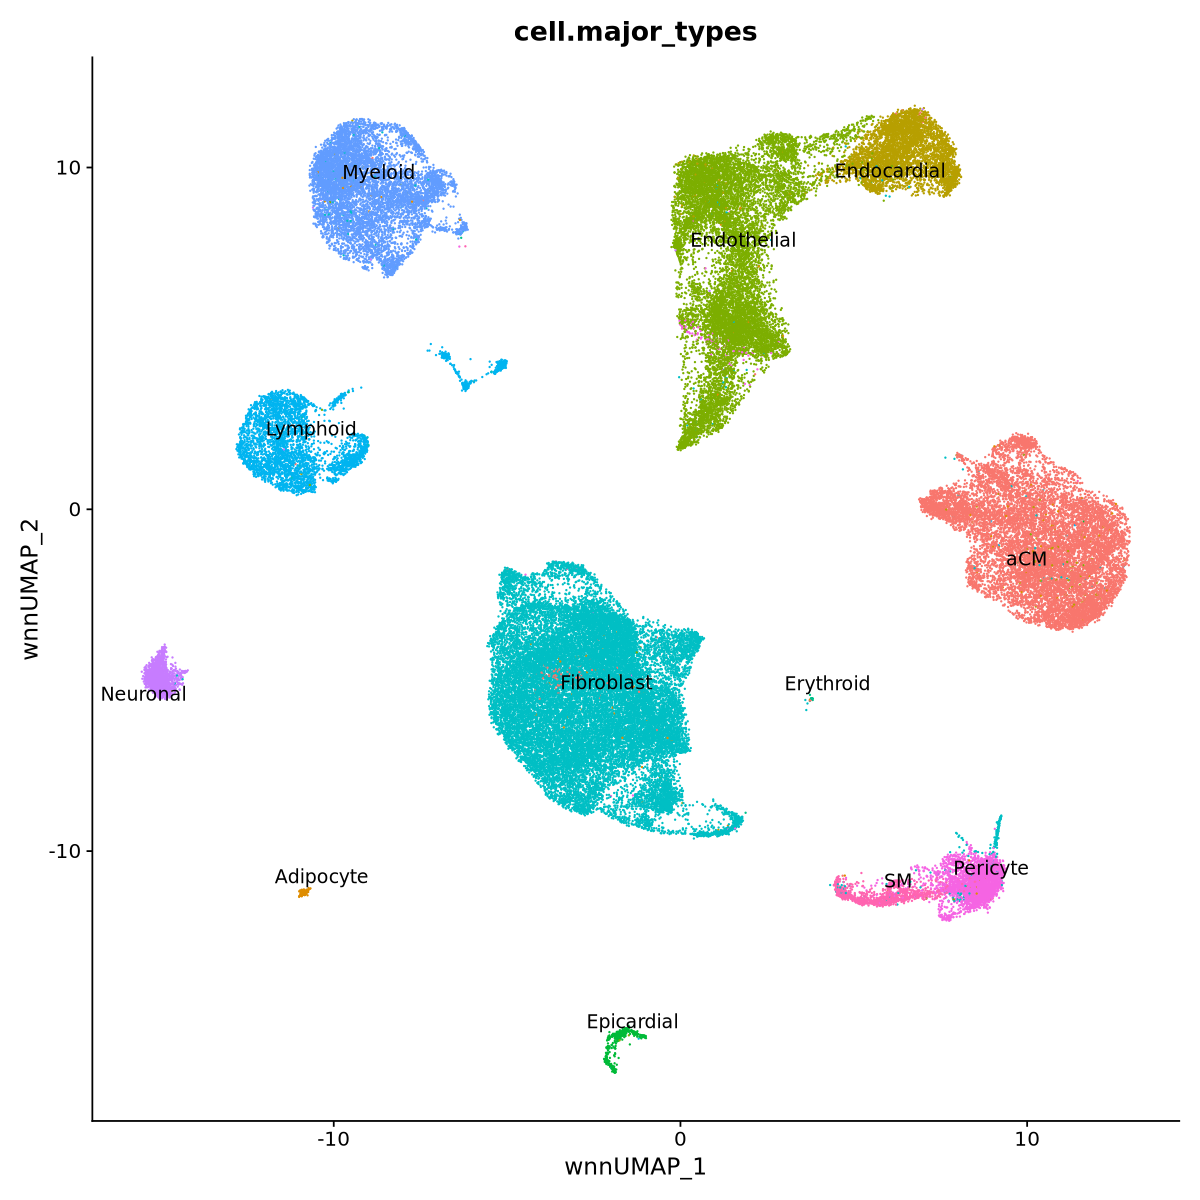

In [158]:
# visualize the results for individual objects
options(repr.plot.width=10, repr.plot.height=10)
DimPlot(adata, reduction = 'umap.wnn', 
        group.by = 'cell.major_types', label=TRUE, repel=TRUE) + NoLegend()


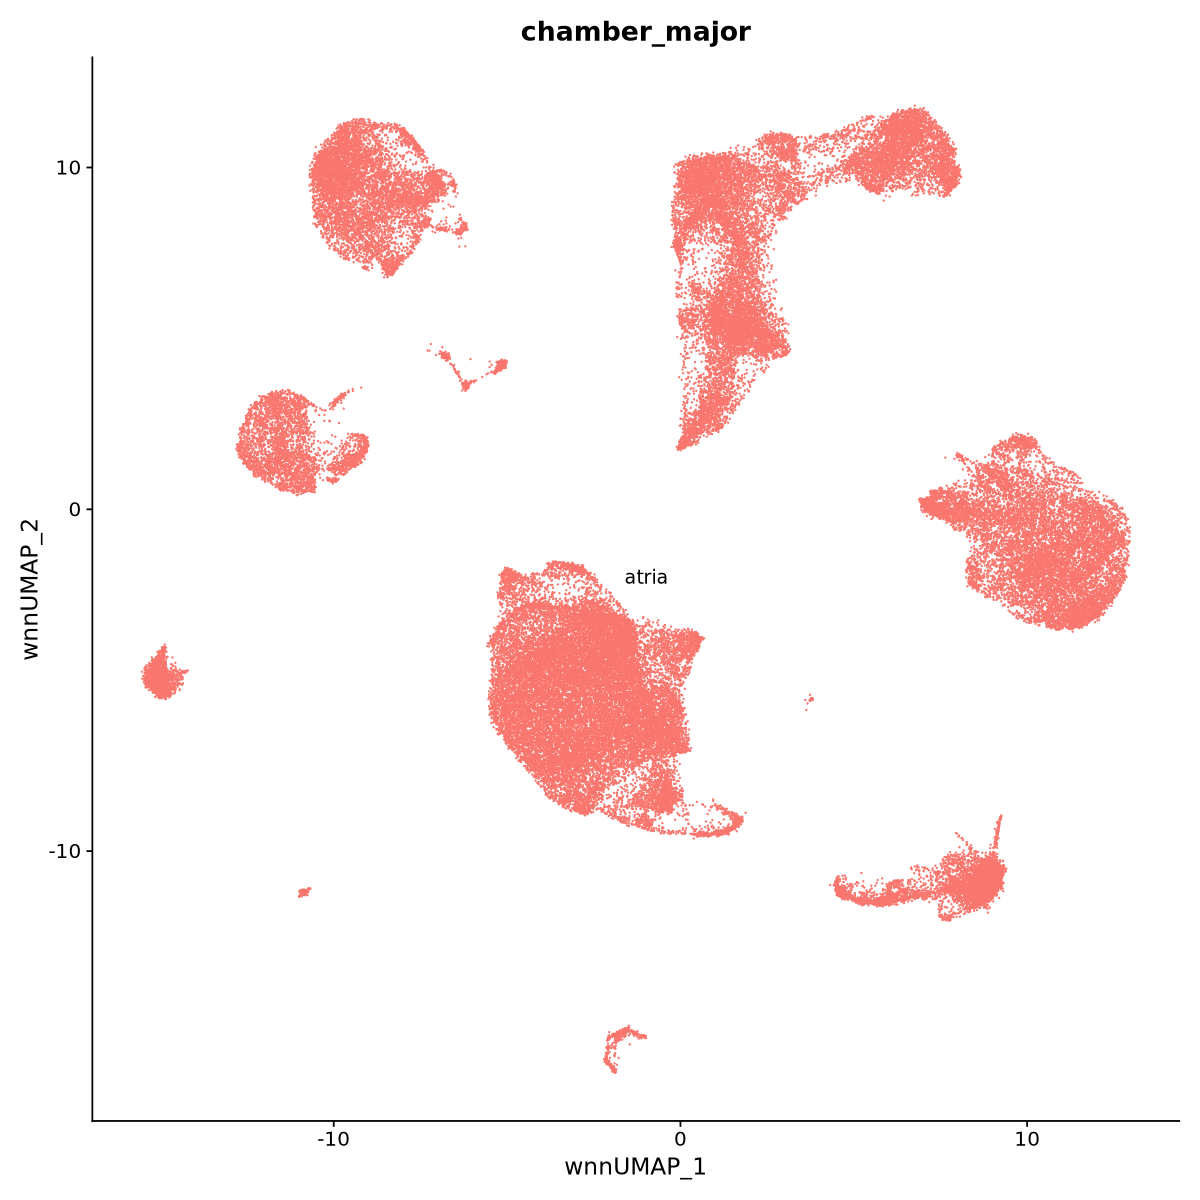

In [159]:
# visualize the results for individual objects
options(repr.plot.width=10, repr.plot.height=10)
DimPlot(adata, reduction = 'umap.wnn', 
        group.by = 'chamber_major', label=TRUE, repel=TRUE) + NoLegend()

In [160]:
peaks.dir = "/nfs/lab/projects/mega_heart/FNIH/multiome/Analysis/1_preprocessing/PeakCalling/3_PeaksMap_byChamber_PeakCalls/RA/"

log_print(paste0("Calling peaks"))
peaks <- CallPeaks(
    object = adata,
    assay = "ATAC",
    group.by = "cell.major_types",
    macs2.path = '/home/luca/.local/bin/macs2',
    broad = FALSE,
    format = "BED", 
    combine.peaks = FALSE,
    outdir = peaks.dir,
    cleanup = FALSE,
    verbose = TRUE)
log_print(paste0("Done"))

[1] "Calling peaks"


Processing file /nfs/lab/projects/mega_heart/FNIH/multiome/Analysis/1_preprocessing/merged.atac_fragments.tsv.gz






[1] "Done"


In [ ]:
file = "/nfs/lab/projects/mega_heart/FNIH/multiome/Analysis/1_preprocessing/PeakCalling/2_PeaksMap_Peakcalls/unified_peaks/FNIH_MultiomePeaks_FiltVariable.bed"
peaks = read.table(file)
peaks = peaks$V1
peaks = StringToGRanges(peaks, sep = c(":", "-"))
peaks

In [ ]:
log_print(paste("attach peaks based ATAC assay"))
DefaultAssay(adata) <- 'RNA'
adata[['ATAC']] <- NULL
adata[['ATAC']] <- chrom_assay_subset
# Remove assays we don't need
adata[['ATAC_windows']] = NULL

# Double check annotation
## adata$cell.major_types OK
adata$cell.sub_types = adata$cell.sub_types_chamber
## adata$cell.sub_types_disease OK
adata$cell.sub_types_chamber = NULL

# ATAC analysis
log_print("Starting ATAC analysis")
DefaultAssay(adata) <- 'ATAC'
log_print("  - RunTFIDF")
adata <- RunTFIDF(adata)
adata <- FindTopFeatures(adata, min.cutoff='q0', verbose=FALSE)
log_print("  - RunSVD")
adata <- RunSVD(adata)

In [ ]:
log_print(" Saving data")
adata = saveRDS(adata, in.dir)
log_print(paste("Done"))